# ASTR3110 Tutorial 4: MCMC

Tutorial 4 of the *'Data Science Techniques in Astrophysics'* course at Macquarie University.

## Learning outcomes from this tutorial

 * Understand what a sampler achieves
 * Understand the terms in Bayes's Formula and how they relate to fitting models
 * Use a MCMC sampler to fit a polynomial model to a simple 1D spectrum
 * Create a triangle plot to show correlations between parameters
 * Extract best-fit and uncertainty estimates from an MCMC chain
 * Apply the Nested Sampling algorithm to the 

## Likelihood, Priors and Bayes's Theorem

In Tutorial 3 we used $\chi^2_{\rm model}$ difference between the model and data as a measure of *goodness of fit* and found the best-fitting model by minimizing its value. However, we often have *prior* independent measurements of the parameters we want to fit. We want this prior information to weight the total $\chi^2$ value so that it prefers parameter values closer to our previous measurements. Each prior parameter estimate contributes its own $\chi^2$ value. For example, for a parameter $p = p_{\rm prior} \pm \sigma_{\rm prior}$, the $\chi^2_{\rm prior}$ value is given by:

$$\chi^2_{\rm prior} = \left(\frac{p_{\rm model} - p_{\rm prior}}{\sigma_{\rm prior}}\right)^2$$.

The total $\chi^2$ value is then given by the sum of all values: $\chi^2 = \chi^2_{\rm model} + \chi^2_{\rm prior}$.

The *likelihood* is a related way of assessing a model fit: *what is the probability, or likelhood $\mathcal{L}$, of getting the observed data given particular values of parameters p?* For Gaussian distributed likelihoods the likelihood is related to $\chi^2$ via

$$\mathcal{L} = exp(-\chi^2\big/2)~~~~or~~~~-2~{\rm ln}(\mathcal{L}) = \chi^2,$$

so that $\chi^2$ is often referred to as the 'log-likelihood'. Because $\mathcal{L}$ is in log-space, likelihoods are *multiplied* to get the total $\mathcal{L}$. From a numerical perspective, the log-likelihood is also a smaller number and less likely to run into computational limits.

### Bayes's Theorem

For a model hypothesis $\mathcal{M}$
and data $\boldsymbol{d}$, the posterior probability for a set of
model parameters $\boldsymbol{\theta}$ is given by Bayes' Theorem
\begin{equation}\label{eqn:bayes_formula}
  {\rm Pr}(\boldsymbol{\theta}|\boldsymbol{d}, \mathcal{M}) =
  \frac{{\rm Pr}(\boldsymbol{d}|\boldsymbol{\theta},
    \mathcal{M})\,{\rm Pr}(\boldsymbol{\theta}|\mathcal{M})}
       {{\rm Pr}(\boldsymbol{d}|\mathcal{M})}.
\end{equation}
The term ${\rm Pr}(\boldsymbol{d}|\boldsymbol{\theta}, \mathcal{M})$
is the probability of the data given the model parameters, also known
as the likelihood $\mathcal{L}$.  The term ${\rm Pr}(\boldsymbol{\theta}|\mathcal{M})$, known as the
prior $\boldsymbol{\pi}(\theta)$, encodes the probability of the
current parameter values given the proposed model, i.e., any {\it a
  priori} information about the values. The final term ${\rm Pr}(\boldsymbol{d}|\mathcal{M})$, known as the
evidence, is the probability of the data given the model and serves to
normalise the posterior distribution so that the total probability is
unity.

## The MCMC Sampler

## Setup for Google Drive and data access

As with the tutorial last week, we will be operating on actual data, so please mount your Gooogle Drive:

In [1]:
# Comment out if running locally
#from google.colab import drive
#drive.mount('/content/gdrive')

In [2]:
# Get into the correct directory (replace with the location of your copy)
#cd "gdrive/"My Drive"/ASTR3110_Tutorial_Notebooks 

We will be processing the same polarised radio-wavelength spectrum as last week. If you haven't already downloaded it, you can get it from this link: [HotSpot.dat](https://github.com/MQ-ASTR3110-2020/ASTR3110_Tutorial_Notebooks/blob/master/DATA/HotSpot.dat). Save this file to your Google Drive under, for example, your 'DATA/' directory.

As a reminder, the file contains 7 columns corresponding to:

[frequency_GHz, I_mJy, Q_mJy, U_mJy, dI_mJy, dQ_mJy, dU_mJy]

and we want to access the columns [0] frequency, [1] flux and [4] uncertainty in flux.

In [3]:
import numpy as np

# Read all columns into an Numpy array
specArr  = np.loadtxt("DATA/HotSpot.dat", dtype="float64", unpack=True)

# Convert Hz to GHz
specArr[0] /= 1e9
print("Array has shape (columns, rows):", specArr.shape)

Array has shape (columns, rows): (7, 198)


As a shortcut, we have written some useful functions in the file ```Imports/util_tute04.py```. These can be imported into the current notebook like this:

In [4]:
# Import the function to evaluate a polynomial
from Imports.util_tute04 import poly5

# Import the function to plot the spectrum
from Imports.util_tute04 import plot_spec_poly5

You can examine *code* by using double question-marks to summon help:

In [5]:
# Examine the code for the imported function
plot_spec_poly5??

You can see that this is our convenience function from Tutorial 3 for plotting the polynomial data and (optionally) best-fitting model. Use it now to check the data has been read in correctly:

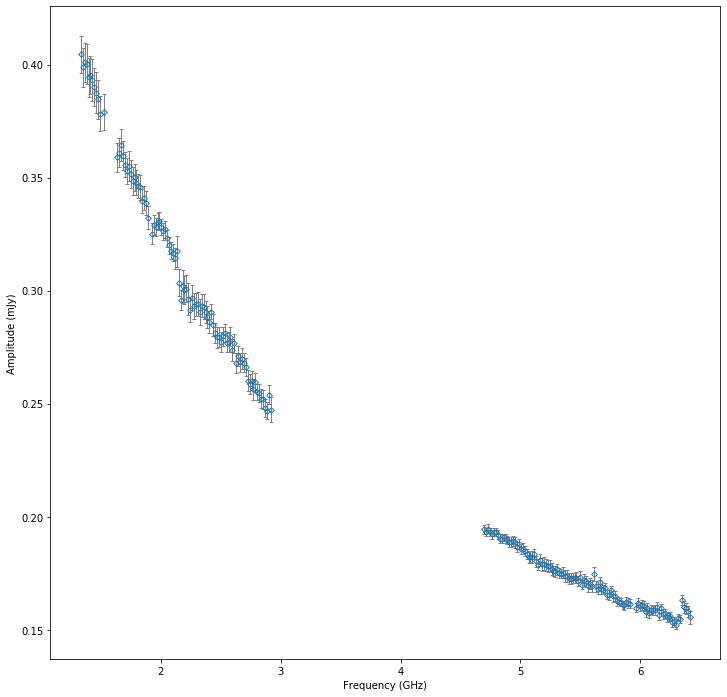

In [6]:
%matplotlib inline

# Set the data arrays from the file
xData = specArr[0]
yData = specArr[1]
dyData = specArr[4]

# Plot the spectrum
plot_spec_poly5(xData, yData, dyData)

## Using MCMC to fit a Polynomial

Here we use the MCMC module ```emcee``` to fit our familiar spectrum using a polynomial model. Using a MCMC sampler has some distinct advantages when it comes to estimating the best-fitting parameters and uncertainty values.

Like before we define a *goodness-of-fit* function. However, this time we formulate it as a log-likelihood:

In [7]:
# Function to calculate the log-likelihood of our model
def lnlike_model(p, xData, yData, dyData):
    """
    Evaluate log-likelihood given the parameters and data
    """
    
    # Bake in the current parameters into the polynomial
    evalPolyFunc = poly5(p)

    # Calculate the y values at the given x values
    yModel = evalPolyFunc(xData)

    # Calculate chi-squared value
    chisqValue = np.sum( ((yModel - yData) / dyData)**2 )
    
    return -chisqValue / 2

ln(like) = -202.67, chi^2 = 405.34, chi^2_red = 2.12


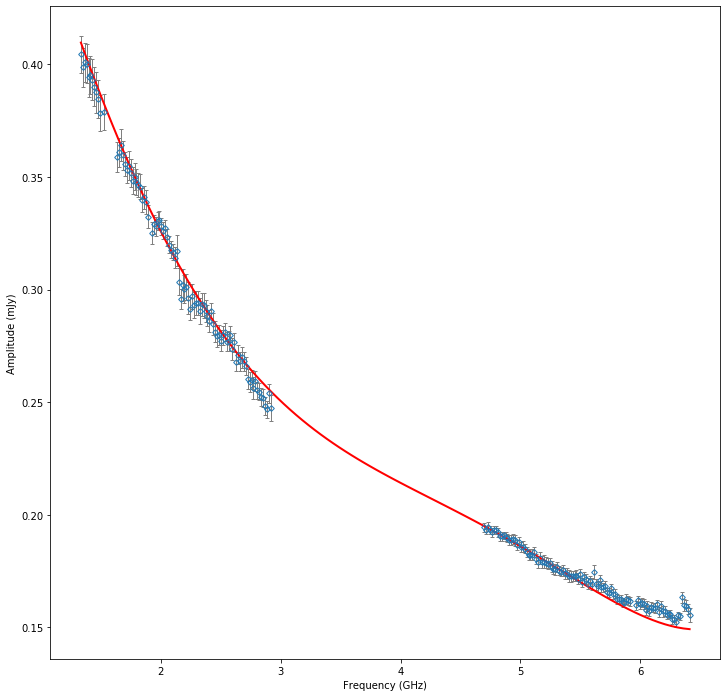

In [8]:
# Check with best fit values from Tutorial 3
pFit = [ 2.46e-04, -4.07e-03,  2.11e-02,
        -1.67e-02, -1.8e-01,  6.41e-01]
lnLikeModel = lnlike_model(pFit, xData, yData, dyData)
chiSq = -2 * lnLikeModel
dof = len(xData) - len(pFit) - 1
chiSqRed = chiSq / dof
print("ln(like) = {:.2f}, chi^2 = {:.2f}, chi^2_red = {:.2f}"
      .format(lnLikeModel, chiSq, chiSqRed))

# Plot the data and fit
plot_spec_poly5(xData, yData, dyData, pFit)

Unlike a gradient-decent method, we are not trying to go directly to a minimum point. Instead we want our guesses to spread out over paramter space *near the best-fit value*. Because the next guess of the chain is weighted by the likelihood, the 'walkers' spend most time near the peak likelihood and less time away from it. The density of samples can be used as a proxy for the posterior likelihood distribution.

For this excercise we will use a module called [emcee](https://emcee.readthedocs.io/en/stable/). This is a pure *Python* implementation of an MCMC sampler that makes many guesses in parallel. You can visualise each guess as a time-series of positions in parameter space that 'walk' all over parameter space - hence we call them 'walkers'.

In [9]:
from Imports import emcee

# Set the sampling parameters
ndim = 6         # Number of parameters
nWalkers = 100   # How many walkers in parallel?

# Randomly initialise a 2D array of walkers between [0, 1]
p0 = [np.random.rand(ndim) for i in range(nWalkers)]

# Define an MCMC sampler object
sampler = emcee.EnsembleSampler(nwalkers = nWalkers,
                                dim      = ndim,
                                lnpostfn = lnlike_model,
                                args     = [xData, yData, dyData],
                                threads  = 2)

Now that we have set our sampler parameters we can set it off walking to the answer. We have made no attempt at making a good initial guess, so our walkers will probably take a while to get close to the best fitting region. This is called the burn-in period and you need to visualise the history of each walker to see when they reach the right area of parameter space.

In [10]:
# Run the sampler
nBurnSteps = 500
sampler.reset()     # Clears any sampler history
pos, prob, state = sampler.run_mcmc(pos0       = p0, 
                                    N          = nBurnSteps, 
                                    storechain = True)

The sampler returns three things:

 * pos =   the last position of each sampler
 * prob =  the last likelihood for each sampler
 * state = the current state of the random number generator
 
The sampler also stores the history of each walker internally - refered to as a chain. We need to visualise the chains for each parameter to see how long it takes *all parameters* to burn-in. Let's define a function to do this:

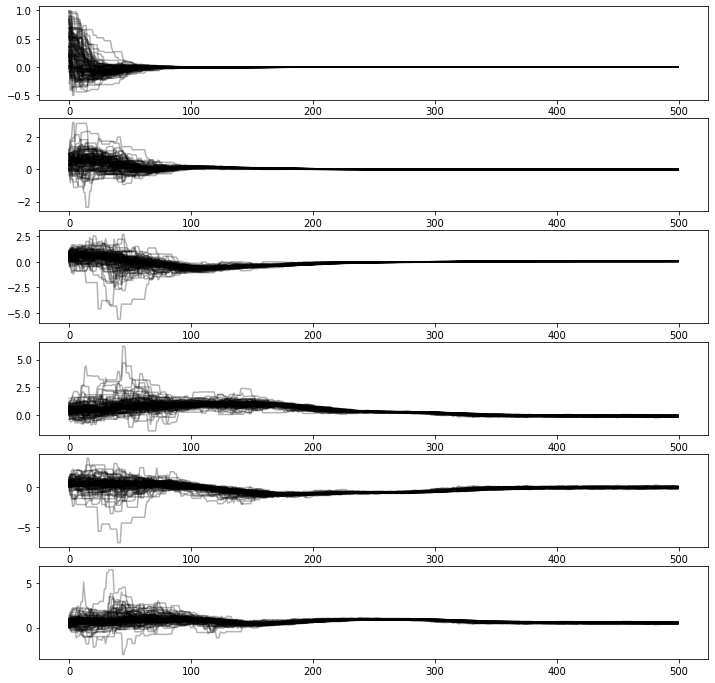

In [11]:
from matplotlib import pyplot as plt

fig = plt.figure()
fig.set_size_inches([12,12])

# Loop through the parameters
for j in range(ndim):
    
    # Add a plot for each parameter
    ax = fig.add_subplot(ndim, 1, j + 1)
    
    # Extract all parallel chains for current parameter
    # This is a 2D array of shape (nWalkers, nSteps).We need to 
    # transpose the array for it to be plotted step on x-axis
    chains = sampler.chain[:,:,j].transpose()
    
    # Plot the chains with time/steps on the bottom
    ax.plot(chains, 'k', alpha = 0.3)

Again, we have made an nice version of this function in the file ```Imports/util_tute04.py```, so you can use that in future. This function plots the samples as points, coloured by likelihood.

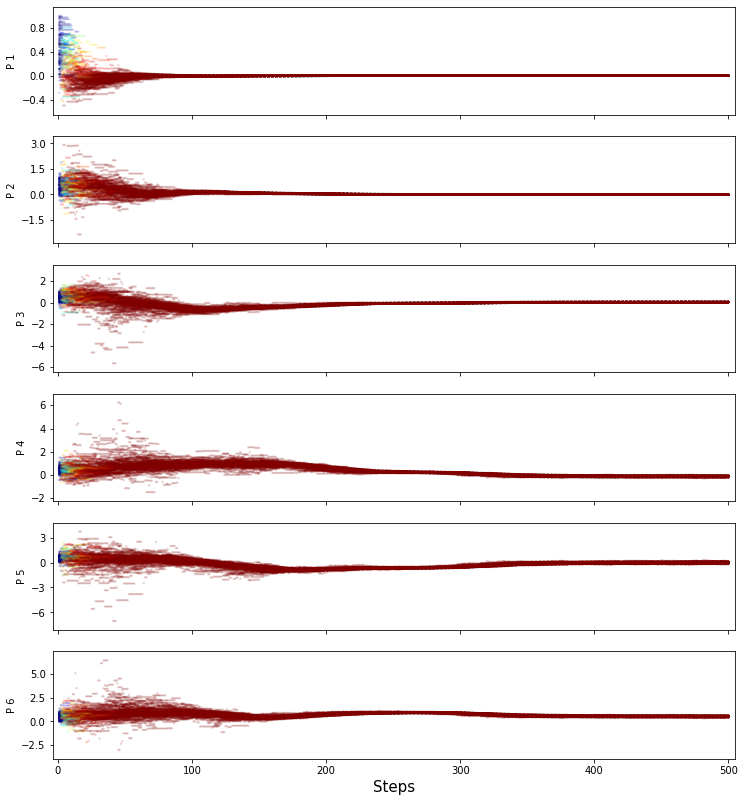

In [12]:
# Import the plotting function and exceute
from Imports.util_tute04 import plot_trace
plot_trace(sampler)

Depending on your initial values, most chains have settled down to a flat (but finitely thick) trace. If they have not then you should run the burn-in for more steps.

Now we want to run the sampler again, but initializing each walker with the converged values, that is, the values on the extreme right of the plot above. These are stored in the ```pos``` variable from the last run of the sampler.

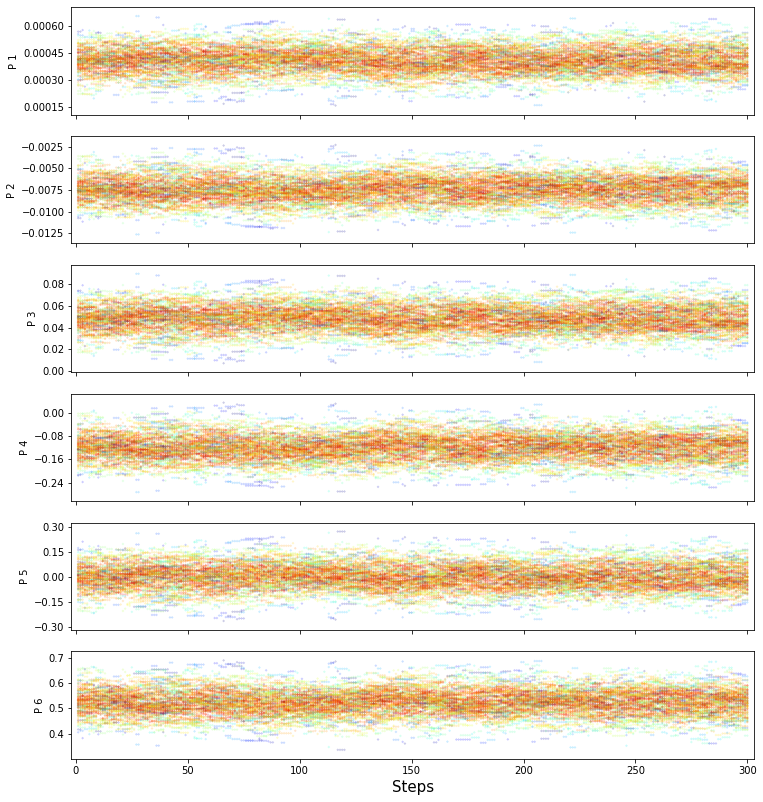

In [13]:
# Run the sampler again from the final burn-in position
nSteps = 300
sampler.reset()      # NB: you must reset the history
pos, prob, state = sampler.run_mcmc(pos0       = pos,  # <- NB
                                    N          = nSteps, 
                                    storechain = True)

# Plot the new trace
plot_trace(sampler)

**Key Point:** 

Looking at a single plot above (e.g., the P6 parameter), we see that the samples are scattered around a single value of ~0.51. A histogram of sampled values is proportional to the *posterior likelihood distribution* of the P6 parameter.

Start by accessing a *flattened* version of the chain: all 100 parallel walker chains merged into one 1D array. Then plot the histogram of the values.

[Text(0, 0.5, 'Sampler Density'), Text(0.5, 0, 'P6 Value')]

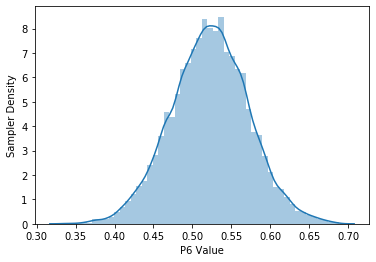

In [14]:
import seaborn as sns

# Access the flattened chain of parameter 6
# The sampler stores a flattened chain as a convenience
# This is just a 1D array of length 100 * 300
fChain6 = sampler.flatchain[:, 5]

# Make a nice looking histogram with seaborne
# Could also use matplotlib plt.hist()

ax = sns.distplot(fChain6, bins=50, kde=True)
ax.set(xlabel='P6 Value', ylabel='Sampler Density')


Now we can make estimates of the best-fit value and uncertainties using the method described in Tutorial 1.

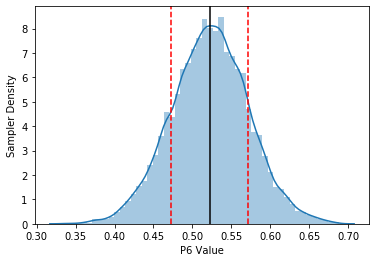

In [15]:
# Use the percentiles function to calculate the crossing points
neg1sig, mean, pos1sig = np.percentile(fChain6, [15.72, 50, 84.27])

# Plot the posterior distribution and values
ax = sns.distplot(fChain6, bins=50, kde=True)
ax.set(xlabel='P6 Value', ylabel='Sampler Density')
ax.axvline(mean, color="k")
ax.axvline(neg1sig, color="r", linestyle="--")
ax.axvline(pos1sig, color="r", linestyle="--")

We can also visualise how each parameter is correlated with every other parameter. Let's try checking how the polynomial coefficent P6 is correlated with P1:

Text(0, 0.5, 'P1 Value')

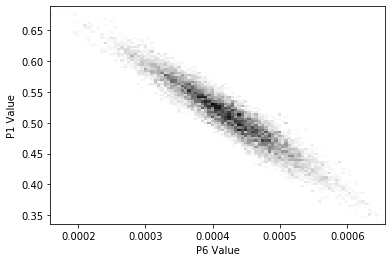

In [16]:
# Access the chains
# Order is ["P6", "P5", "P4", "P3", "P2", "P1"]
fChain1 = sampler.flatchain[:, 5]
fChain6 = sampler.flatchain[:, 0]

# Make a 2D histogram
nXY, xBins, yBins = np.histogram2d(x=fChain6, y=fChain1, bins=100)
plt.pcolor(xBins, yBins, nXY, cmap="gray_r")

# Label the figure
plt.xlabel("P6 Value")
plt.ylabel("P1 Value")

Here we can see the P6 is anti-correlated with P1: solutions with higher values of P6 drive the P1 value down. 

Rather than making these plots by hand, there is a module called ```corner``` that is dedicated to plotting the results of MCMC samplers and similar. 

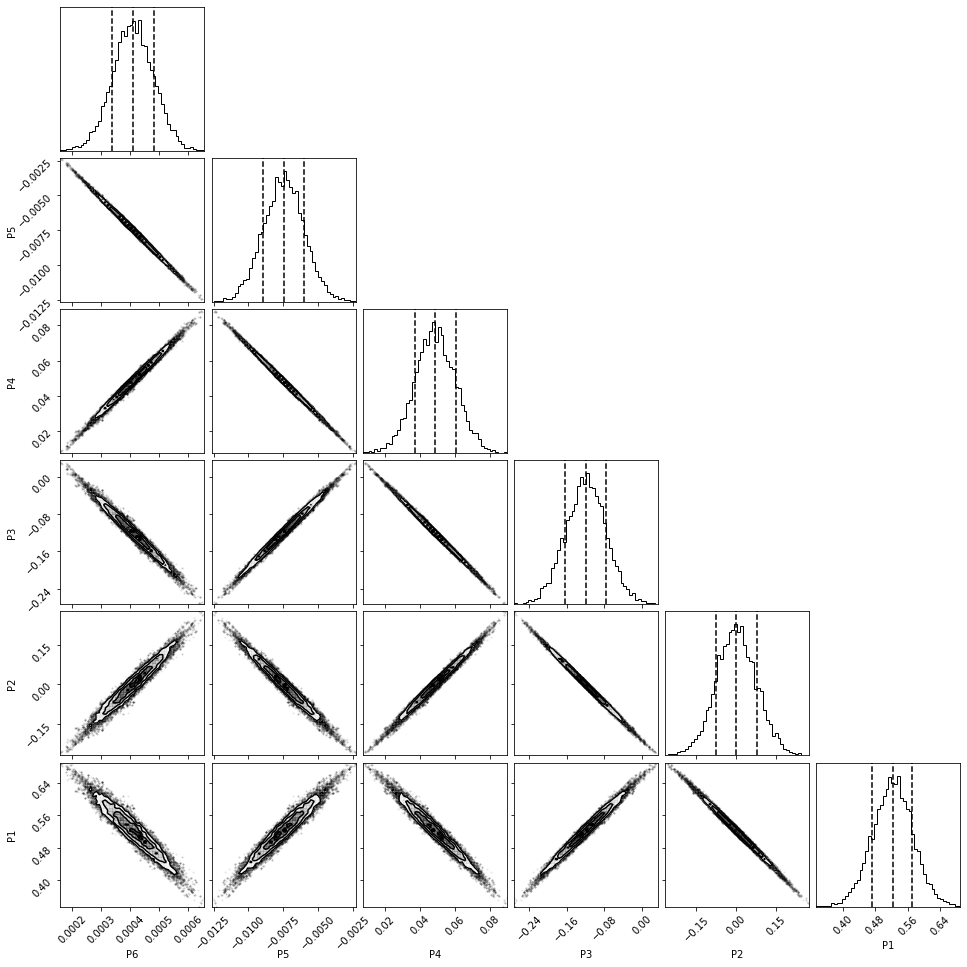

In [17]:
from Imports import corner

# Make a labeled corner figure
cornerFig = corner.corner(xs=sampler.flatchain,
                          bins=50,
                          labels=["P6", "P5", "P4", "P3", "P2", "P1"],
                          verbose=False,
                          quantiles=[0.1572, 0.5, 0.8427])

At this point we should calculate the best-fitting results and plot the model over the data as a visual check.

P6 = 0.0004087 (+7.34216e-05, -7.34216e-05)
P5 = -0.007455 (+0.0014422, -0.0014422)
P4 = 0.04819 (+0.0120114, -0.0120114)
P3 = -0.119 (+0.0422974, -0.0422974)
P2 = -0.0008257 (+0.0784277, -0.0784277)
P1 = 0.5231 (+0.0480545, -0.0480545)


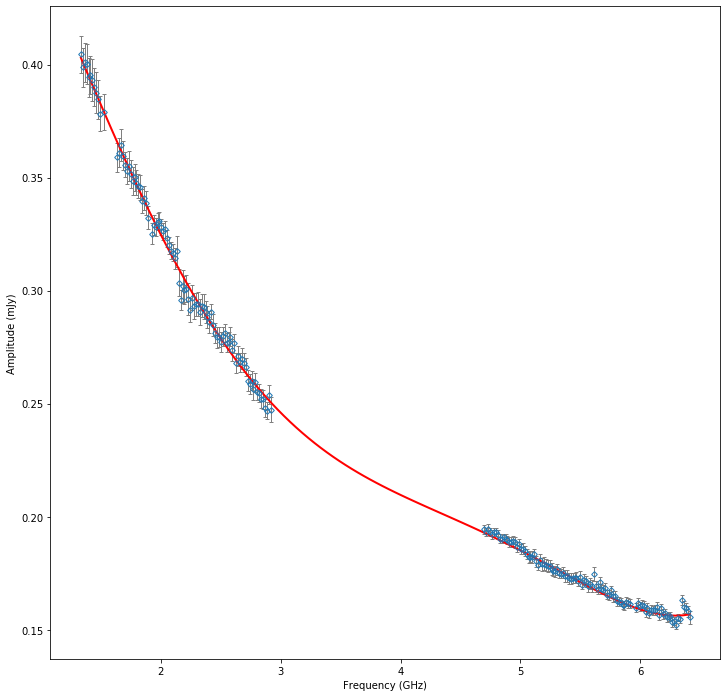

In [18]:
# Loop over the free parameters
pBest = []
labels = ["P6", "P5", "P4", "P3", "P2", "P1"]
for i in range(ndim):
    
    # Access the chain for the current parameter
    fChain = sampler.flatchain[:, i]
    
    # Work out the best fit value (mean) and +/- 1-sigma values.
    neg1sig, mean, pos1sig = np.percentile(fChain, [15.72, 50, 84.27])
    pBest.append(mean)
    
    # Calculate the uncertainties:
    errLow = mean - neg1sig
    errHigh = pos1sig - mean
    
    # Print the results
    print("{} = {:.4g} (+{:3g}, -{:3g})"
          .format(labels[i], mean, errHigh, errHigh))
    
# Plot the results
plot_spec_poly5(xData, yData, dyData, pBest)